# Prophet

- 페이스북사에서 만든 시계열 예측 모델
- PC에서는 fbprophet을 설치해야 함,  conda install -c conda-forge fbprophet
- 기존에 설치된 다른 라이브러리와 버전 문제가 생기기 쉽다. 이 때는 가상환경 (virtual env)을 하나 만들고 그 가상환경에서 설치하고 실행하면 된다.
- PC에서 설치가 안되면 colab에서 실행한다

## Prophet 장점

- prophet 모델은 현재 값 까지만 알려주고 모든 미래값을 한번에 예측한다
- walk forward 모델이 아니다 (순차적으로 미래 값을 사용하지 않는다)
- 결측치가 있어도 동작한다 (ARIMA 등 수리 모델에서는 결측치가 있으면 오류 발생)
- 세일 기간 등 특별한 이벤트를 모델 자체에 반영할 수 있다 (holiday 지정 기능 사용)

## import

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 15})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [75]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score               

# 전력사용 예측 

In [76]:
power = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv",
                 parse_dates=['timestamp'])
power.set_index("timestamp", inplace=True)

print(power.shape)
power[:3]

(26304, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


## 데이터

- 컬럼명을 반드시 ['ds','y']로 지정해야야 함

In [58]:
df = power.resample('D').sum()
df.reset_index(inplace=True)
df.drop('temp', axis=1, inplace=True)
df.columns = ['ds','y']
df

,ds,y
0,2012-01-01,71562.0
1,2012-01-02,76841.0
2,2012-01-03,87887.0
3,2012-01-04,92168.0
4,2012-01-05,88096.0
...,...,...
1091,2014-12-27,73845.0
1092,2014-12-28,74678.0
1093,2014-12-29,84486.0
1094,2014-12-30,88810.0


### 훈련데이터, 검증 데이터 나누기

In [60]:
# 1096개 데이터중 900개를 훈련 데이터로 사용
cut = 900
train_data = df[:cut]
test_data = df[cut:]

## 모델 학습과 예측 수행


### 학습 수행
- 학습에는 train_data 사용

In [61]:
m = Prophet()
m.fit(train_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 예측 수행
- 학습 기간을 포함해서 전 구간의 날짜 정보를 준다

In [62]:
all_range = df.copy()
all_range.drop('y', axis=1, inplace=True)
all_range

,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05
...,...
1091,2014-12-27
1092,2014-12-28
1093,2014-12-29
1094,2014-12-30


- 예측치는 forecast.yhat에 들어 있다 (y_pred)

In [63]:
forecast = m.predict(all_range)
forecast[:3]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,76258.200214,71745.575713,81646.792882,76258.200214,76258.200214,710.239804,710.239804,710.239804,-4754.814565,-4754.814565,-4754.814565,5465.054369,5465.054369,5465.054369,0.0,0.0,0.0,76968.440017
1,2012-01-02,76270.106353,77940.026328,87915.188400,76270.106353,76270.106353,6601.431115,6601.431115,6601.431115,1096.293937,1096.293937,1096.293937,5505.137178,5505.137178,5505.137178,0.0,0.0,0.0,82871.537468
2,2012-01-03,76282.012493,78256.599746,88194.144895,76282.012493,76282.012493,7199.205323,7199.205323,7199.205323,1645.547173,1645.547173,1645.547173,5553.658150,5553.658150,5553.658150,0.0,0.0,0.0,83481.217816


## 결과 보기


### 함수 plot() 사용

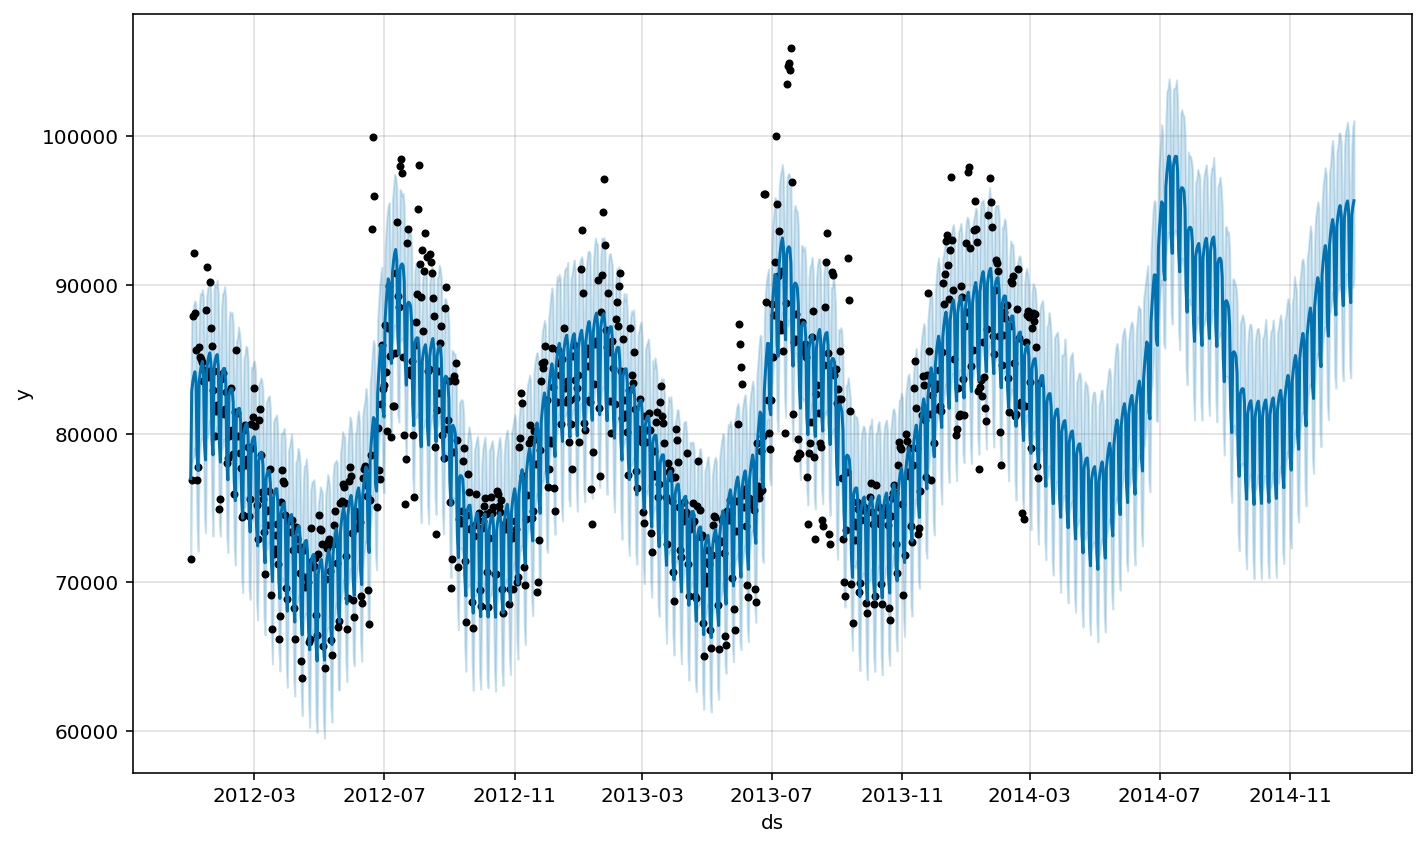

In [64]:
m.plot(forecast)
from datetime import datetime
import matplotlib.pyplot as plt
# 구간 자세히 보기 (아래 해제)
# plt.xlim([datetime(2014, 1, 1), datetime(2014, 5, 30)])

### 시계열 컴포넌트 보기

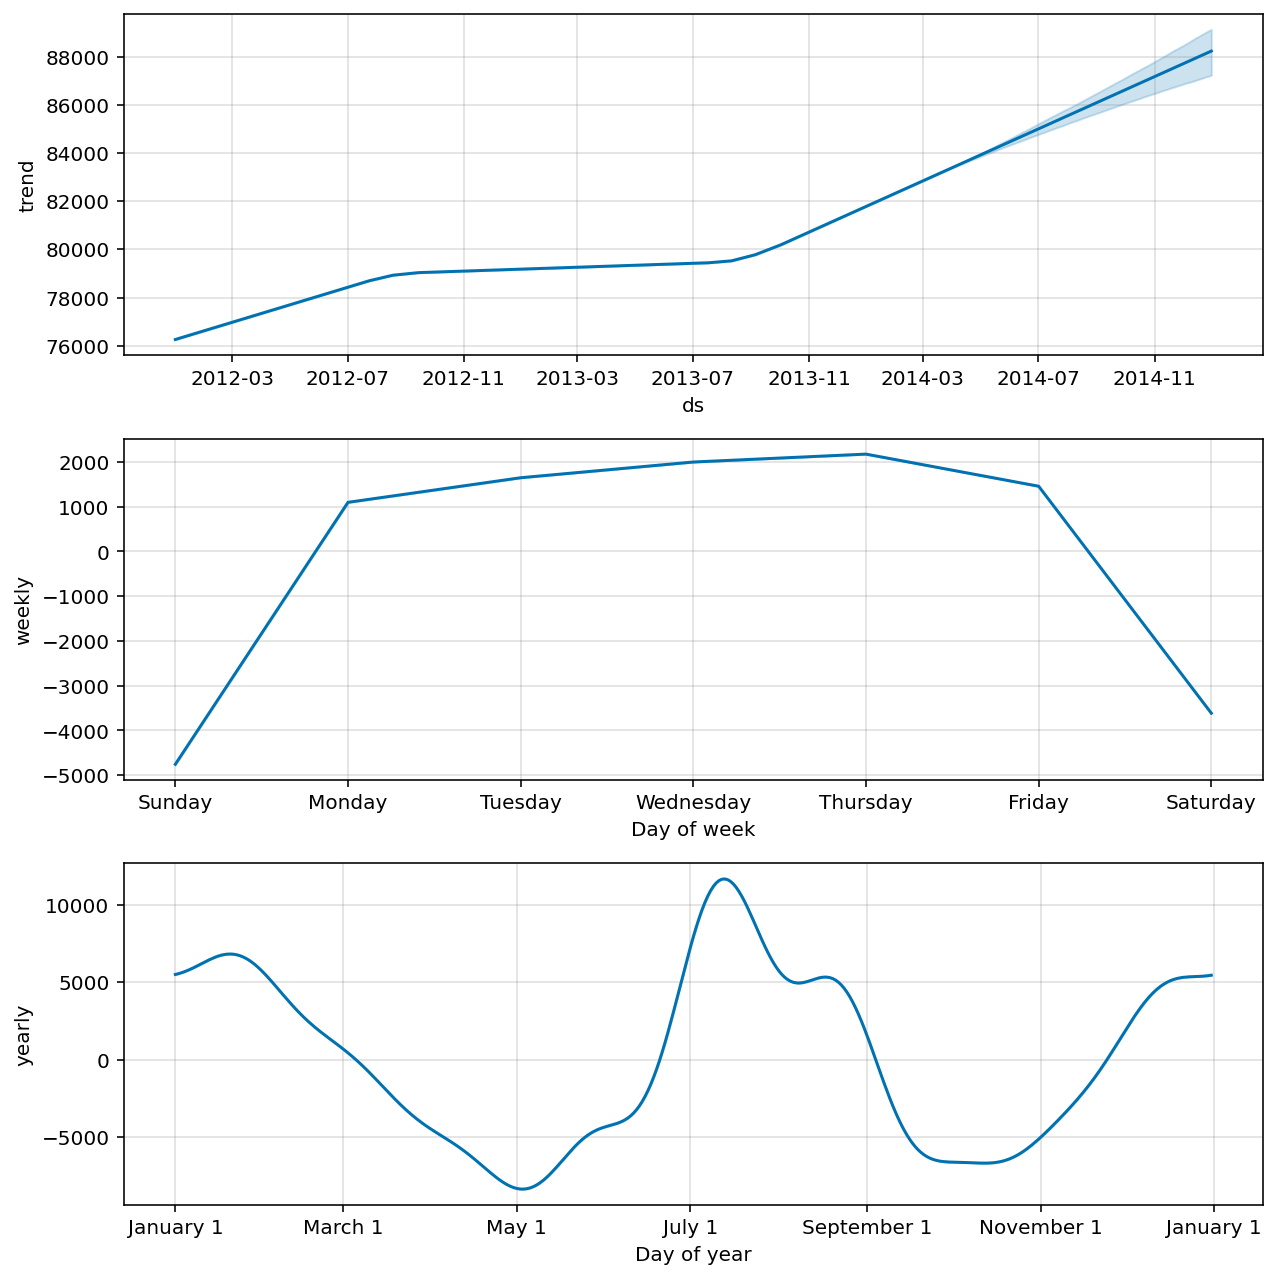

In [65]:
_ = m.plot_components(forecast)

### 결과 성능 평가

In [66]:
y_test = test_data.y
y_test.shape

(296,)

In [67]:
y_pred = forecast[cut:].yhat
y_pred.shape

(296,)

In [68]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

In [69]:
def plot_reg_result(y_test, y_pred, N=50):
    y_t=y_test.ravel()
    y_p=y_pred.ravel()
    plt.plot(y_t[:N], 'r.-', label='y_test')
    plt.plot(y_p[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_t, y_t - y_p, s=5)

In [70]:
show_reg_result(y_test,y_pred)

Max Error:  26145.63
Mean Absolute Error:  6683.173
Root Mean Squared Error:  7862.073
R-Squared:  -0.496


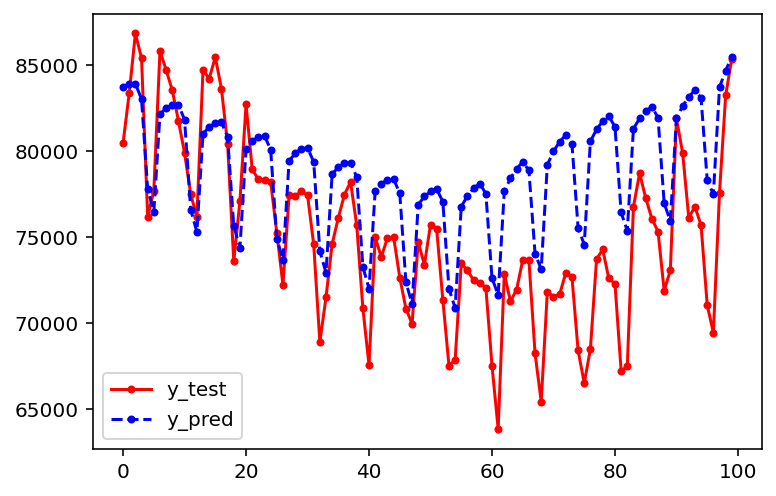

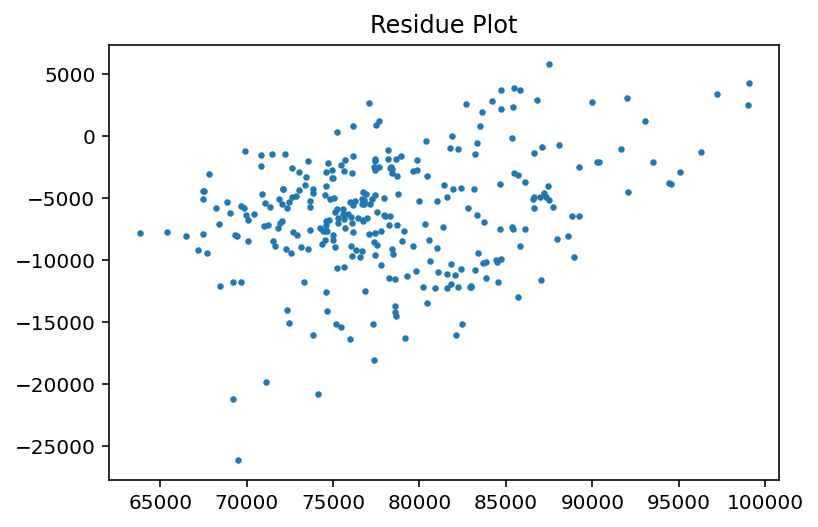

In [73]:
plot_reg_result(y_test, y_pred, 100)

## (연습) 훈련 데이터로 950개를 사용하는 모델을 만드시오

In [93]:
# (풀이)



# 자동차 판매량 예측

## 데이터

In [48]:
path = 'https://raw.githubusercontent.com/StillWork/data/master/car_sales.csv'
car = pd.read_csv(path)
print(car.shape)
car[:3]

(108, 2)


,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026


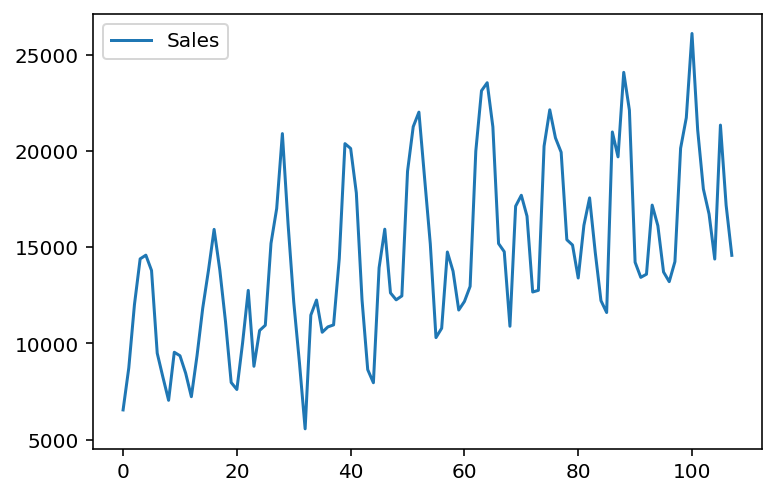

In [49]:
car.plot()

In [50]:
car.columns = ['ds', 'y']
car['ds']= pd.to_datetime(car['ds'])
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


In [51]:
car[:3]

,ds,y
0,1960-01-01,6550
1,1960-02-01,8728
2,1960-03-01,12026


### 훈련과 검증 데이터
- 최종 1년 데이터를 test 데이터로 사용

In [52]:
df = car.copy()
train_data = df[:-12]
test_data = df[-12:]

## 모델 학습과 예측 수행

In [41]:
all_range = df.drop("y", axis=1) 
all_range

,ds
0,1960-01-01
1,1960-02-01
2,1960-03-01
3,1960-04-01
4,1960-05-01
...,...
103,1968-08-01
104,1968-09-01
105,1968-10-01
106,1968-11-01


In [42]:
model = Prophet()
model.fit(train_data)

forecast = model.predict(all_range)
y_pred = forecast[-12:]['yhat'].values
y_test = test_data['y'].values

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 결과 보기

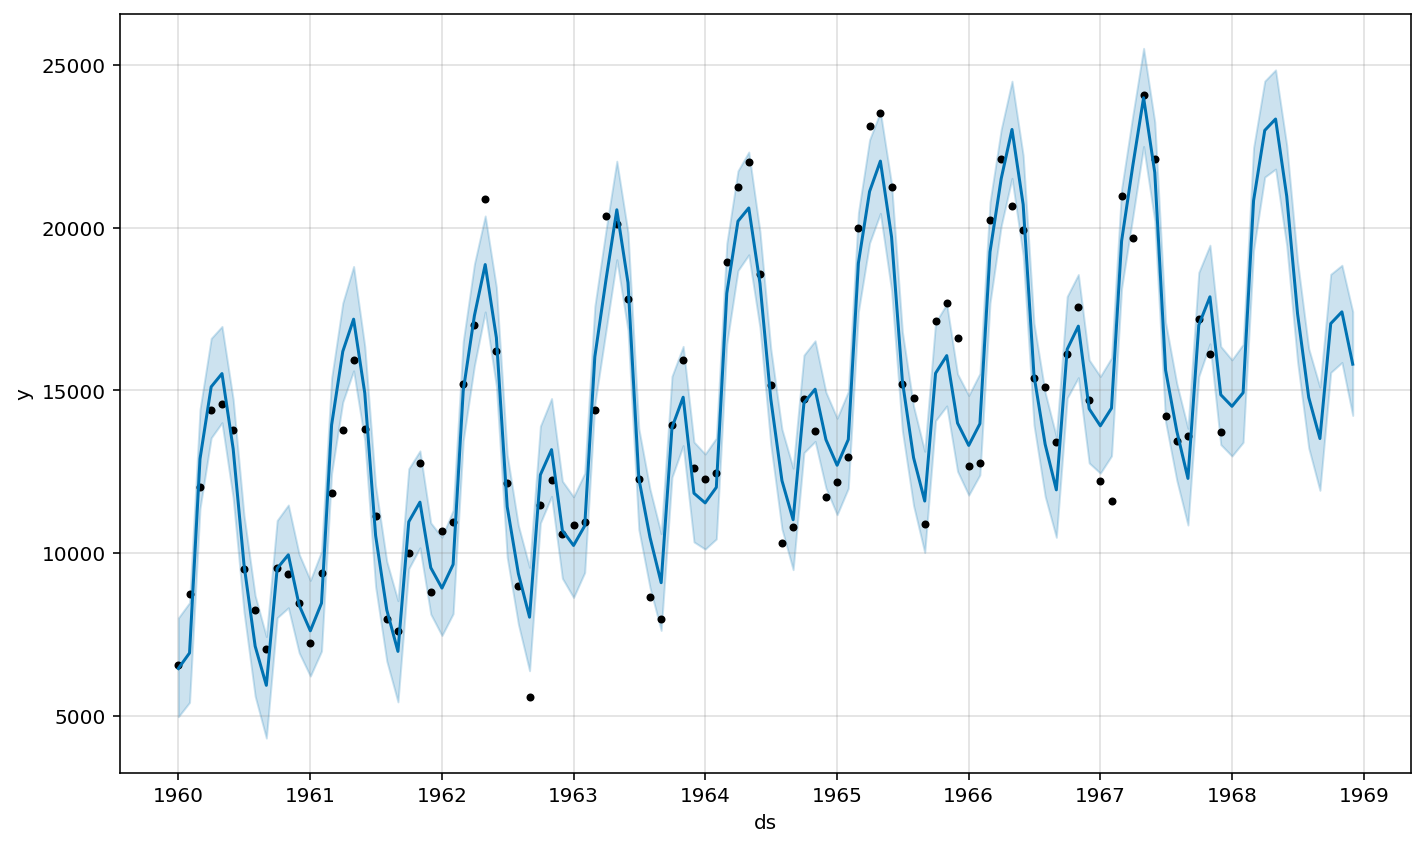

In [43]:
_ = model.plot(forecast)

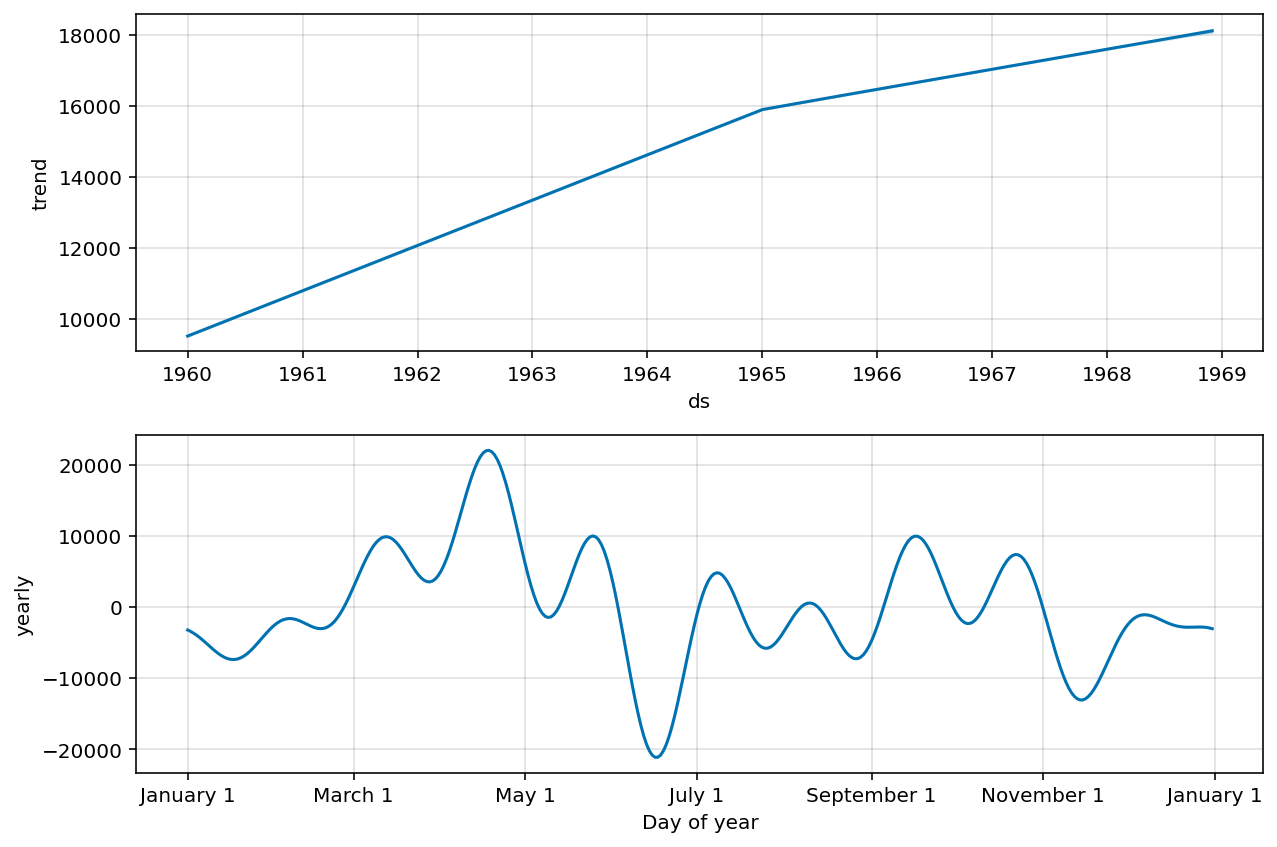

In [44]:
_ = model.plot_components(forecast)

In [45]:
show_reg_result(y_test,y_pred)

Max Error:  4283.967
Mean Absolute Error:  1336.814
Root Mean Squared Error:  1749.191
R-Squared:  0.782


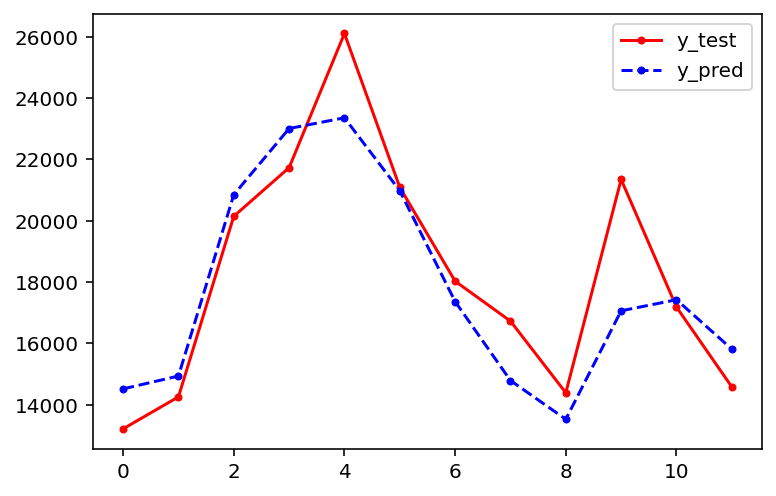

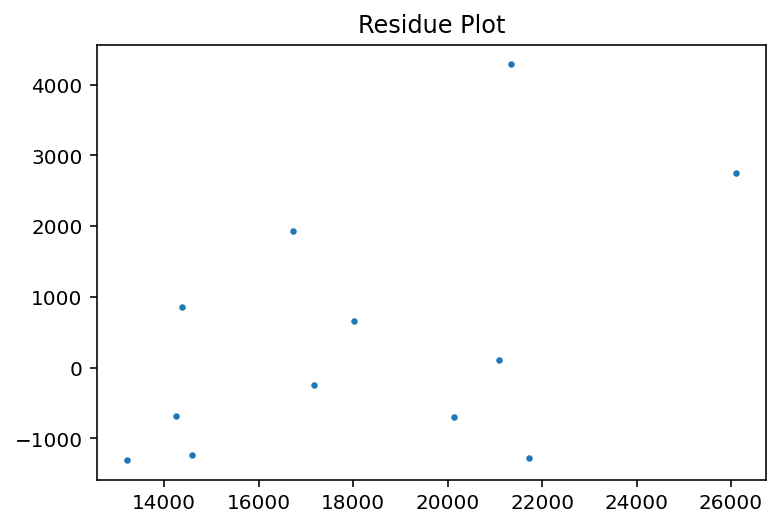

In [46]:
plot_reg_result(y_test,y_pred)

## (연습) 자동차 판매 데이터에서 최근 2년치를 예측하는 모델을 만드시오

In [92]:
# (풀이)



# 정답

## (연습) 훈련 데이터로 950개를 사용하는 모델을 만드시오

In [ ]:
df = power.resample('D').sum()
df.reset_index(inplace=True)
df.drop('temp', axis=1, inplace=True)
df.columns = ['ds','y']
cut = 950
train_data = df[:cut]
test_data = df[cut:]
m = Prophet()
m.fit(train_data)
all_range = df.copy()
all_range.drop('y', axis=1, inplace=True)
forecast = m.predict(all_range)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
y_test = test_data.y
y_pred = forecast[cut:].yhat
show_reg_result(y_test,y_pred)

Max Error:  16154.277
Mean Absolute Error:  5263.559
Root Mean Squared Error:  6046.279
R-Squared:  -0.212


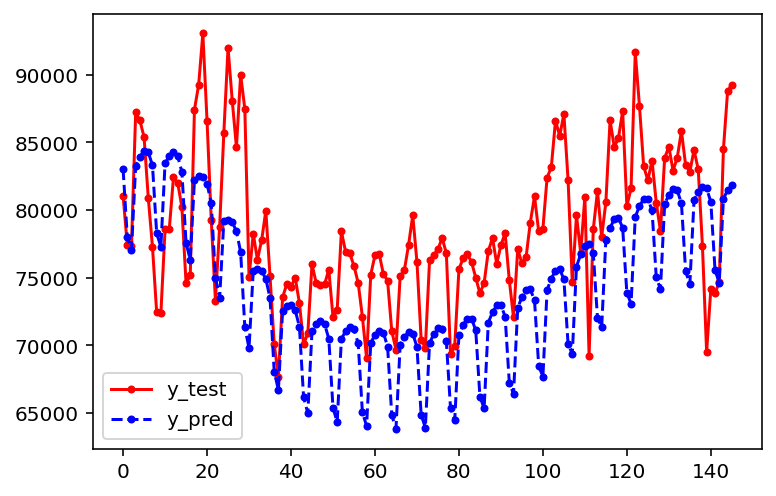

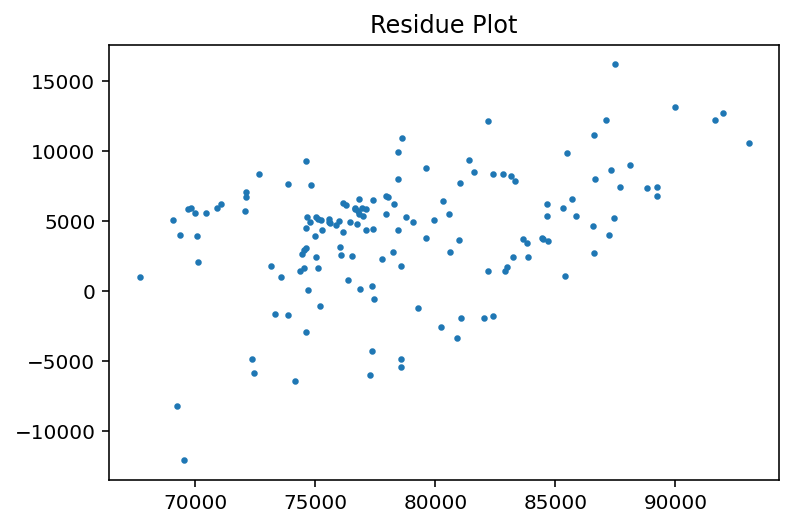

In [ ]:
plot_reg_result(y_test,y_pred,500)

## (연습) 자동차 판매 데이터에서 최근 2년치를 예측하는 모델을 만드시오

In [ ]:
df = car.copy()
train_data = df[:-24]
test_data = df[-24:]
all_range = df.drop("y", axis=1) 
model = Prophet()
model.fit(train_data)

forecast = model.predict(all_range)
y_pred = forecast[-24:]['yhat'].values
y_test = test_data['y'].values


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


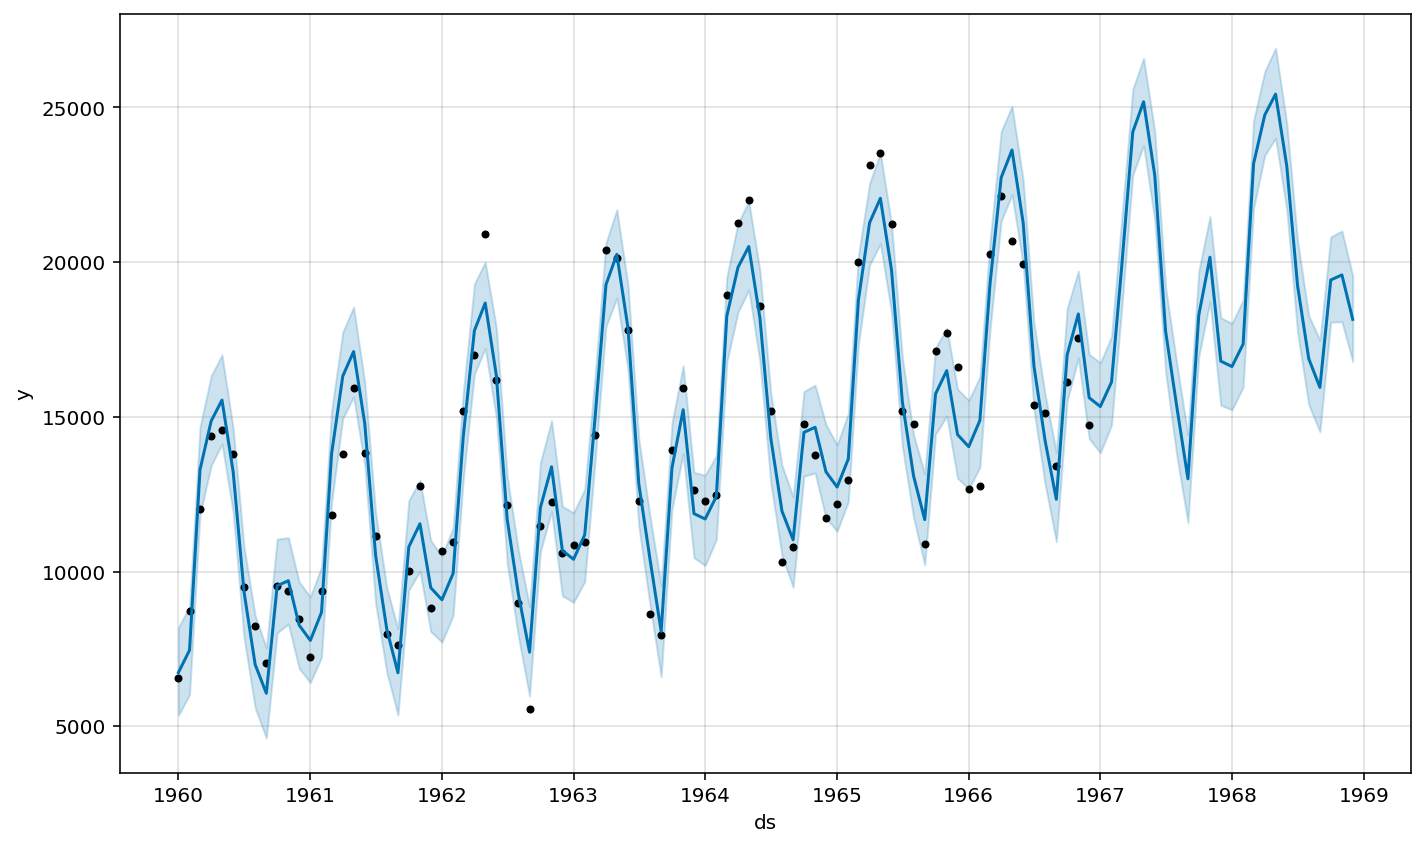

In [ ]:
_ = model.plot(forecast)

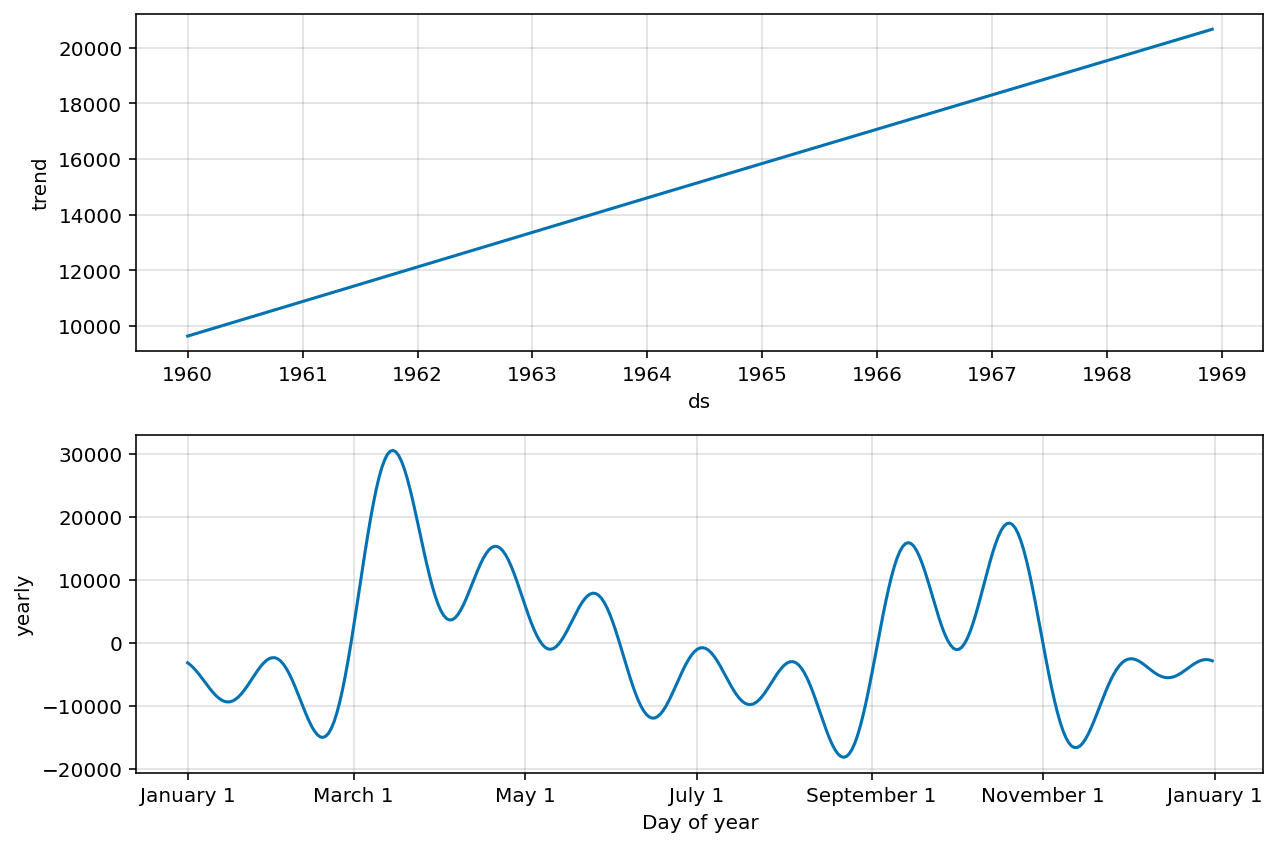

In [ ]:
_ = model.plot_components(forecast)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  4515.65
Mean Absolute Error:  2311.457
Root Mean Squared Error:  2641.612
R-Squared:  0.556


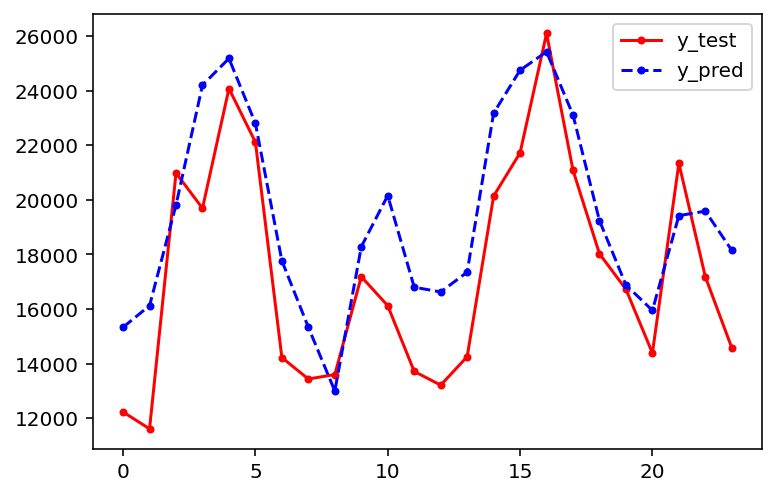

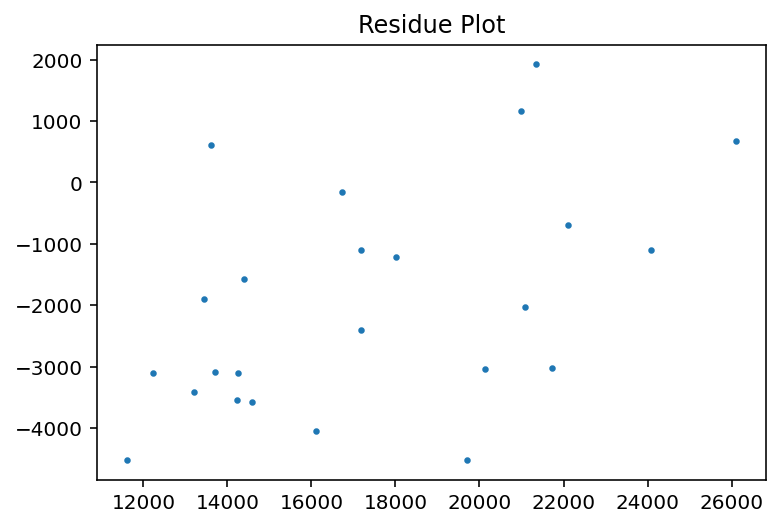

In [ ]:
plot_reg_result(y_test, y_pred, N=100)